### Import Library

Reference

* https://github.com/cure-lab/LTSF-Linear
* https://today-1.tistory.com/60

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from argparse import Namespace
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Data Directory

In [45]:
feature_path = "../../data/merge_data_V6_eng_V1.csv"
region_feature_path = "../../data/nationwide_eng_V1.csv"

### Load Data

In [46]:
interest_rate = ["call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg"]
stock = ["KOSPI_index", "KOSDAQ_index", "NASDAQ_index"]
money_supply = ["M2_Korea", "M2_USA"]
liquidity = ["broad_liquidity"]
inflation = ["CPI_growth_rate"]
exchange_rate = ["USD_KRW_exchange_rate"]
gdp = ["real_GDP_growth_rate"]
construction = ["residential_building_start_status", "residential_building_permit_status"]
construction_production = ["construction_production_index_seasonally_adjusted"]

column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production

nf = pd.read_csv(region_feature_path)[:17].T.dropna()
nf.columns = nf.iloc[0]
nf = nf.iloc[1:].astype(float)

df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
df = pd.concat([df,nf], axis = 1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

date = 'Date'
df = df.reset_index(names=date) 
df[date] = pd.to_datetime(df[date]) 

df.reset_index(drop=True, inplace=True)
df.index.name = "num"

In [47]:
df

Date       Date  call_interest_rate  government_bond_3yr  \
num                                                        
0    2006-01-15                3.74                 5.02   
1    2006-02-15                3.92                 4.87   
2    2006-03-15                3.97                 4.93   
3    2006-04-15                3.97                 4.95   
4    2006-05-15                3.96                 4.78   
..          ...                 ...                  ...   
217  2024-02-15                3.58                 3.35   
218  2024-03-15                3.47                 3.31   
219  2024-04-15                3.52                 3.44   
220  2024-05-15                3.53                 3.43   
221  2024-06-15                3.55                 3.26   

Date  deposit_bank_loan_rate_avg  KOSPI_index  KOSDAQ_index  NASDAQ_index  \
num                                                                         
0                           5.79  1379.323810    708.266190   2289.991504   
1                           5.76  1341.722000    656.840500   2273.666311   
2                           5.89  1331.720000    657.500000   2300.255668   
3                           5.83  1415.921000    693.712500   2338.677362   
4                           5.89  1388.834500    663.351000   2245.281816   
..                           ...          ...           ...           ...   
217                         4.85  2630.416316    845.114211  15808.935010   
218                         4.85  2699.587000    890.640000  16216.295508   
219                         4.77  2674.250000    861.700000  15950.863548   
220                         4.78  2710.446000    854.389500  16536.317161   
221                         4.71  2748.160526    854.670000  17495.891653   

Date   M2_Korea   M2_USA  broad_liquidity  ...  \
num                                        ...   
0     1027.2356   6730.3              8.7  ...   
1     1034.3588   6754.9              8.1  ...   
2     1038.7277   6769.5              8.5  ...   
3     1046.4002   6807.0              7.9  ...   
4     1056.9430   6813.9              8.8  ...   
..          ...      ...              ...  ...   
217   3929.8580  20761.8              4.6  ...   
218   3996.2166  20862.9              5.6  ...   
219   4013.2282  20881.1              4.6  ...   
220   4014.1308  20959.4              5.2  ...   
221   4037.5808  21020.1              5.5  ...   

Date  Sejong_apartment_sale_price_index  Gyeonggi_apartment_sale_price_index  \
num                                                                            
0                                  75.7                                 66.3   
1                                  77.0                                 67.2   
2                                  82.0                                 68.0   
3                                  77.4                                 68.9   
4                                  78.0                                 69.8   
..                                  ...                                  ...   
217                               128.0                                136.6   
218                               128.7                                136.6   
219                               127.9                                137.0   
220                               126.6                                137.1   
221                               127.8                                138.1   

Date  Gangwon_apartment_sale_price_index  Chungbuk_apartment_sale_price_index  \
num                                                                             
0                                   58.1                                 64.0   
1                                   58.4                                 65.2   
2                                   57.6                                 65.6   
3                                   58.2                                 66.5   
4                                   59.

In [48]:
target_column = [
    "Seoul",
    "Busan",
    "Daegu",
    "Incheon",
    "Gwangju",
    "Daejeon",
    "Ulsan",
    "Sejong",
    "Gyeonggi",
    "Gangwon",
    "Chungbuk",
    "Chungnam",
    "Jeonbuk",
    "Jeonnam",
    "Gyeongbuk",
    "Gyeongnam",
    "Jeju",
]

### xPatch

In [49]:
class EMA(nn.Module):
    """
    Exponential Moving Average (EMA) block to highlight the trend of time series
    """
    def __init__(self, alpha):
        super(EMA, self).__init__()
        # self.alpha = nn.Parameter(alpha)    # Learnable alpha
        self.alpha = alpha

    # Optimized implementation with O(1) time complexity
    def forward(self, x):
        # x: [Batch, Input, Channel]
        # self.alpha.data.clamp_(0, 1)        # Clamp learnable alpha to [0, 1]
        _, t, _ = x.shape
        powers = torch.flip(torch.arange(t, dtype=torch.double), dims=(0,))
        weights = torch.pow((1 - self.alpha), powers)
        divisor = weights.clone()
        weights[1:] = weights[1:] * self.alpha
        weights = weights.reshape(1, t, 1)
        divisor = divisor.reshape(1, t, 1)
        x = torch.cumsum(x * weights, dim=1)
        x = torch.div(x, divisor)
        return x.to(torch.float32)

class DECOMP(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, ma_type, alpha, beta):
        super(DECOMP, self).__init__()
        if ma_type == 'ema':
            self.ma = EMA(alpha)

    def forward(self, x):
        moving_average = self.ma(x)
        res = x - moving_average
        return res, moving_average
    
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x
    
class Network(nn.Module):
    def __init__(self, seq_len, pred_len, patch_len, stride, padding_patch):
        super(Network, self).__init__()

        # Parameters
        self.pred_len = pred_len

        # Non-linear Stream
        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        self.dim = patch_len * patch_len
        self.patch_num = (seq_len - patch_len)//stride + 1
        if padding_patch == 'end': # can be modified to general case
            self.padding_patch_layer = nn.ReplicationPad1d((0, stride)) 
            self.patch_num += 1

        # Patch Embedding
        self.fc1 = nn.Linear(patch_len, self.dim)
        self.gelu1 = nn.GELU()
        self.bn1 = nn.BatchNorm1d(self.patch_num)
        
        # CNN Depthwise
        self.conv1 = nn.Conv1d(self.patch_num, self.patch_num,
                               patch_len, patch_len, groups=self.patch_num)
        self.gelu2 = nn.GELU()
        self.bn2 = nn.BatchNorm1d(self.patch_num)

        # Residual Stream
        self.fc2 = nn.Linear(self.dim, patch_len)

        # CNN Pointwise
        self.conv2 = nn.Conv1d(self.patch_num, self.patch_num, 1, 1)
        self.gelu3 = nn.GELU()
        self.bn3 = nn.BatchNorm1d(self.patch_num)

        # Flatten Head
        self.flatten1 = nn.Flatten(start_dim=-2)
        self.fc3 = nn.Linear(self.patch_num * patch_len, pred_len * 2)
        self.gelu4 = nn.GELU()
        self.fc4 = nn.Linear(pred_len * 2, pred_len)

        # Linear Stream
        # MLP
        self.fc5 = nn.Linear(seq_len, pred_len * 4)
        self.avgpool1 = nn.AvgPool1d(kernel_size=2)
        self.ln1 = nn.LayerNorm(pred_len * 2)

        self.fc6 = nn.Linear(pred_len * 2, pred_len)
        self.avgpool2 = nn.AvgPool1d(kernel_size=2)
        self.ln2 = nn.LayerNorm(pred_len // 2)

        self.fc7 = nn.Linear(pred_len // 2, pred_len)

        # Streams Concatination
        self.fc8 = nn.Linear(pred_len * 2, pred_len)

    def forward(self, s, t):
        # x: [Batch, Input, Channel]
        # s - seasonality
        # t - trend
        
        s = s.permute(0,2,1) # to [Batch, Channel, Input]
        t = t.permute(0,2,1) # to [Batch, Channel, Input]
        
        # Channel split for channel independence
        B = s.shape[0] # Batch size
        C = s.shape[1] # Channel size
        I = s.shape[2] # Input size
        s = torch.reshape(s, (B*C, I)) # [Batch and Channel, Input]
        t = torch.reshape(t, (B*C, I)) # [Batch and Channel, Input]

        # Non-linear Stream
        # Patching
        if self.padding_patch == 'end':
            s = self.padding_patch_layer(s)
        s = s.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        # s: [Batch and Channel, Patch_num, Patch_len]
        
        # Patch Embedding
        s = self.fc1(s)
        s = self.gelu1(s)
        s = self.bn1(s)

        res = s

        # CNN Depthwise
        s = self.conv1(s)
        s = self.gelu2(s)
        s = self.bn2(s)

        # Residual Stream
        res = self.fc2(res)
        s = s + res

        # CNN Pointwise
        s = self.conv2(s)
        s = self.gelu3(s)
        s = self.bn3(s)

        # Flatten Head
        s = self.flatten1(s)
        s = self.fc3(s)
        s = self.gelu4(s)
        s = self.fc4(s)

        # Linear Stream
        # MLP
        t = self.fc5(t)
        t = self.avgpool1(t)
        t = self.ln1(t)

        t = self.fc6(t)
        t = self.avgpool2(t)
        t = self.ln2(t)

        t = self.fc7(t)

        # Streams Concatination
        x = torch.cat((s, t), dim=1)
        x = self.fc8(x)

        # Channel concatination
        x = torch.reshape(x, (B, C, self.pred_len)) # [Batch, Channel, Output]

        x = x.permute(0,2,1) # to [Batch, Output, Channel]

        return x

class xPatch(nn.Module):
    def __init__(self, configs):
        super(xPatch, self).__init__()

        # Parameters
        seq_len = configs.seq_len   # lookback window L
        pred_len = configs.pred_len # prediction length (96, 192, 336, 720)
        c_in = configs.enc_in       # input channels

        # Patching
        patch_len = configs.patch_len
        stride = configs.stride
        padding_patch = configs.padding_patch

        # Normalization
        self.revin = configs.revin
        self.revin_layer = RevIN(c_in,affine=True,subtract_last=False)

        # Moving Average
        self.ma_type = configs.ma_type
        alpha = configs.alpha       # smoothing factor for EMA (Exponential Moving Average)
        beta = configs.beta         # smoothing factor for DEMA (Double Exponential Moving Average)

        self.decomp = DECOMP(self.ma_type, alpha, beta)
        self.net = Network(seq_len, pred_len, patch_len, stride, padding_patch)
        # self.net_mlp = NetworkMLP(seq_len, pred_len) # For ablation study with MLP-only stream
        # self.net_cnn = NetworkCNN(seq_len, pred_len, patch_len, stride, padding_patch) # For ablation study with CNN-only stream

    def forward(self, x):
        # x: [Batch, Input, Channel]

        # Normalization
        if self.revin:
            x = self.revin_layer(x, 'norm')

        if self.ma_type == 'reg':   # If no decomposition, directly pass the input to the network
            x = self.net(x, x)
            # x = self.net_mlp(x) # For ablation study with MLP-only stream
            # x = self.net_cnn(x) # For ablation study with CNN-only stream
        else:
            seasonal_init, trend_init = self.decomp(x)
            x = self.net(seasonal_init, trend_init)

        # Denormalization
        if self.revin:
            x = self.revin_layer(x, 'denorm')

        return x

### Tools for predict

In [ ]:
def standardization(train_df, test_df, not_col, target): 
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_dict = {}
    std_dict = {}
    
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
        if x in target:
            mean_dict[x] = mean
            std_dict[x] = std
    return train_df_, test_df_, mean_dict, std_dict

def time_slide_df(df, window_size, forecast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0] - window_size - forecast_size + 1):
        # x: features from the past window_size (including columns)
        x = df_.loc[idx:idx+window_size-1, target].values 
        # get target value for future forecast size 
        y = df_.loc[idx+window_size:idx+window_size+forecast_size-1, target].values
        # get date value for future forecast size 
        date_ = df_.loc[idx+window_size:idx+window_size+forecast_size-1, date].values
        
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

### Common Experiment Setting

In [7]:
window_size = 3
forecast_size= 3 

train_df = df[0:177]
test_df = df[177-forecast_size:]
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"

### Train and Save model (Input V1: Variables used in MLP of FA-SEM)
* input: "call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status", f"{target}"
* window_size = 3
* forecast_size= 3 

In [67]:
### Experiment Setting
version = "V1"
batch_size = 16
kernel_size = 25
epoch_ = 500
lr = 0.001
patience = 20  # easrly stopping

columns_to_use = ["call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status"] \
                    + nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    enc_in= len(columns_to_use), # feature_size
    patch_len = 4,
    stride = 2,
    padding_patch = 'end',
    revin = True,
    ma_type = 'ema',
    alpha = 0.3,
    beta = 0.3,
)

In [68]:
# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
xPatch_model = xPatch(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(xPatch_model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

 95%|█████████▌| 476/500 [01:26<00:04,  5.49it/s]


Early stopping triggered.


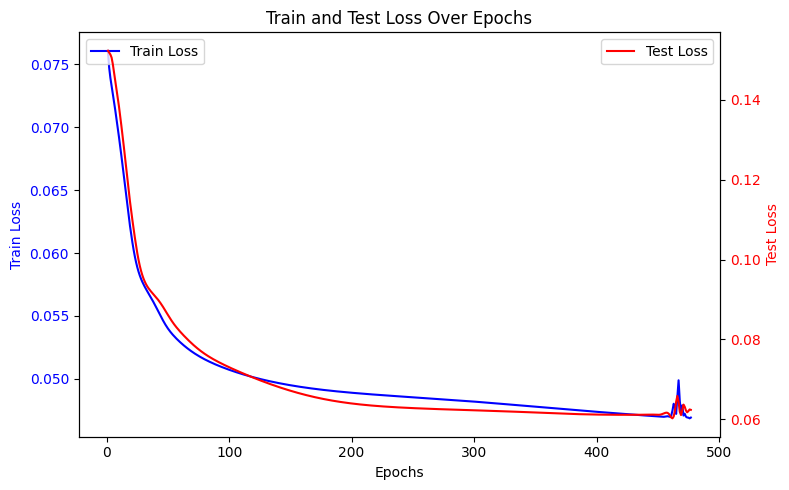

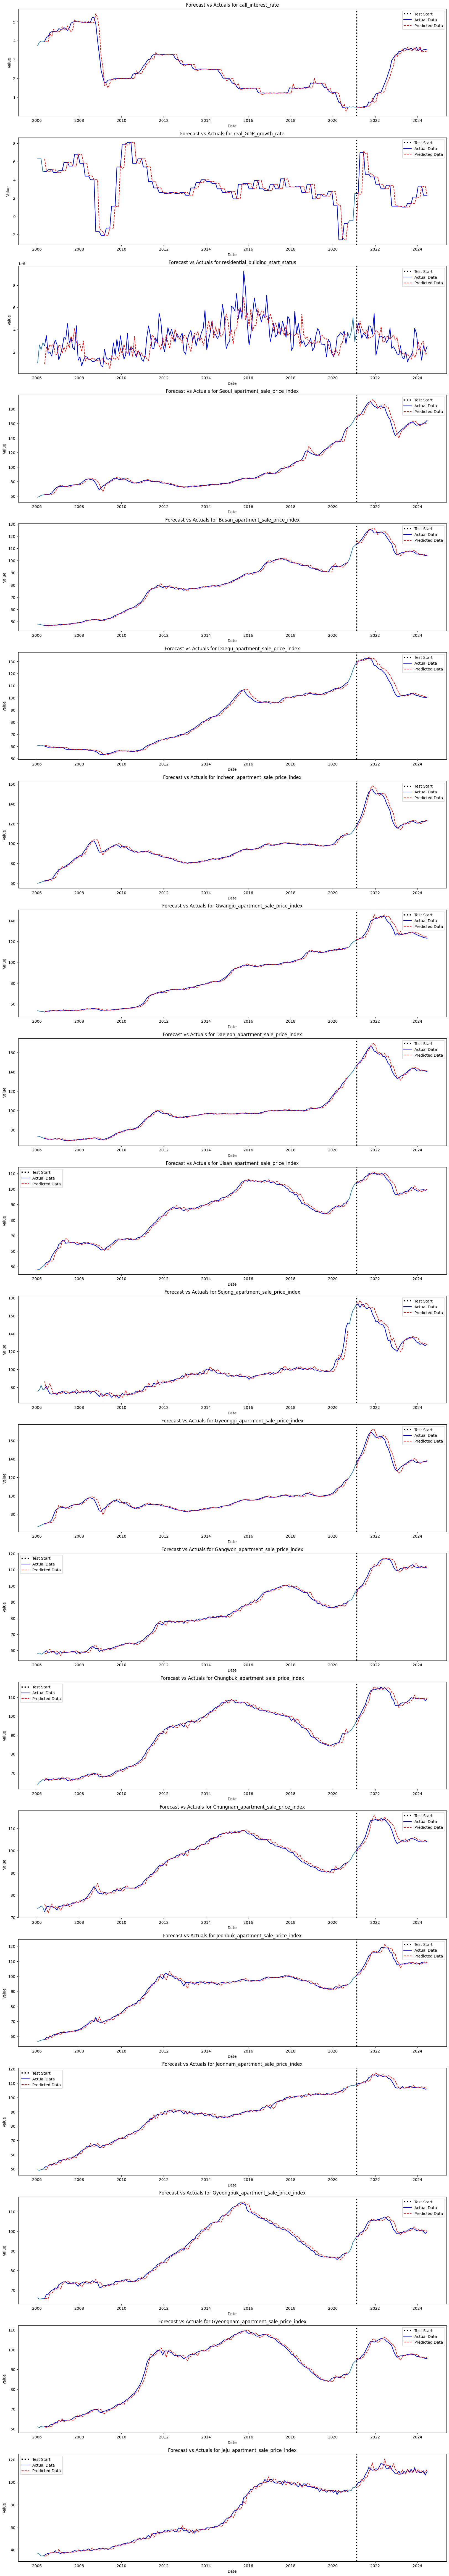

In [53]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    xPatch_model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = xPatch_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    xPatch_model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = xPatch_model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(xPatch_model.state_dict(), f"./xPatch{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
xPatch_model.load_state_dict(torch.load(f"./xPatch{version}.pth"))  # 최적 모델 로드
xPatch_model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = xPatch_model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = xPatch_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    

In [70]:
# Load model and Evaluate
xPatch_model.load_state_dict(torch.load(f"./xPatch{version}.pth"))  # 최적 모델 로드
xPatch_model.eval()

with torch.no_grad():
    for data, target in test_dl:
        test_output = xPatch_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    

<Figure size 2000x12000 with 0 Axes>

### Train and Save model (Input V2: All variables used in FA-SEM-MLP)
* input: "call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg", "KOSPI_index", "KOSDAQ_index", "NASDAQ_index", "M2_Korea", "M2_USA", "broad_liquidity", "CPI_growth_rate", "USD_KRW_exchange_rate", "real_GDP_growth_rate", "residential_building_start_status", "residential_building_permit_status", "construction_production_index_seasonally_adjusted", 
f"{target}"
* window_size = 3
* forecast_size= 3 

In [71]:
### Experiment Setting
version = "V2"
batch_size = 16
kernel_size = 25
epoch_ = 500
lr = 0.001
patience = 20  # easrly stopping

columns_to_use = column + nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    enc_in= len(columns_to_use), # feature_size
    patch_len = 4,
    stride = 2,
    padding_patch = 'end',
    revin = True,
    ma_type = 'ema',
    alpha = 0.3,
    beta = 0.3,
)

In [72]:
# Prepare Dataset
# 정규화된 train_df, test_df와 각 칼럼에 대한 mean_, std_ 딕셔너리가 출력됨. 
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
xPatch_model = xPatch(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(xPatch_model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

 60%|█████▉    | 298/500 [00:49<00:33,  5.97it/s]


Early stopping triggered.


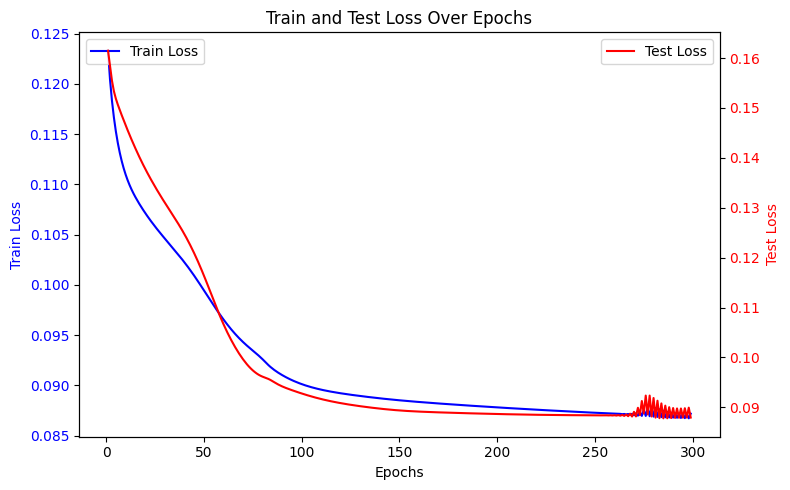

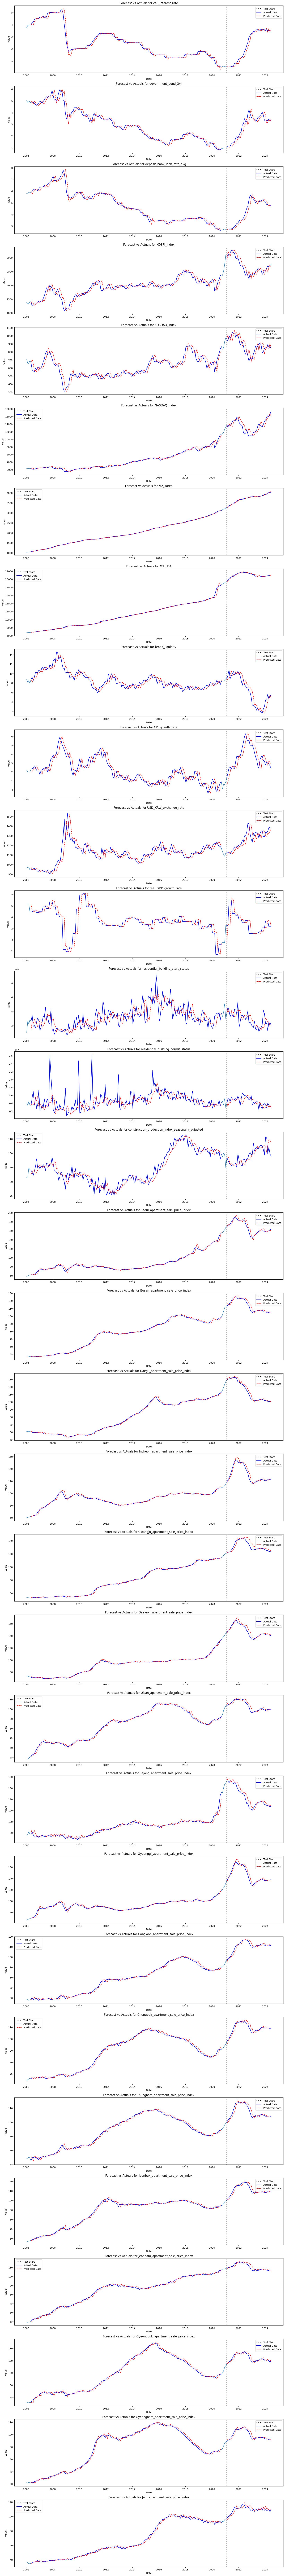

In [55]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    xPatch_model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = xPatch_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    xPatch_model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = xPatch_model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(xPatch_model.state_dict(), f"./xPatch{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
xPatch_model.load_state_dict(torch.load(f"./xPatch{version}.pth"))  # 최적 모델 로드
xPatch_model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = xPatch_model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = xPatch_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    

In [73]:
# Load model and Evaluate
xPatch_model.load_state_dict(torch.load(f"./xPatch{version}.pth"))  # 최적 모델 로드
xPatch_model.eval()

with torch.no_grad():
    for data, target in test_dl:
        test_output = xPatch_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    

<Figure size 2000x19200 with 0 Axes>

### Train and Save model (Input V3: Just using Past target)
* input: f"{target}"
* window_size = 3
* forecast_size= 3 

In [74]:
### Experiment Setting
version = "V3"
batch_size = 16
kernel_size = 25
epoch_ = 500
lr = 0.001
patience = 20  # easrly stopping

columns_to_use = nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    enc_in= len(columns_to_use), # feature_size
    patch_len = 4,
    stride = 2,
    padding_patch = 'end',
    revin = True,
    ma_type = 'ema',
    alpha = 0.3,
    beta = 0.3,
)

In [75]:
# Prepare Dataset
# 정규화된 train_df, test_df와 각 칼럼에 대한 mean_, std_ 딕셔너리가 출력됨. 
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
xPatch_model = xPatch(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(xPatch_model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

 50%|█████     | 251/500 [00:37<00:37,  6.65it/s]


Early stopping triggered.


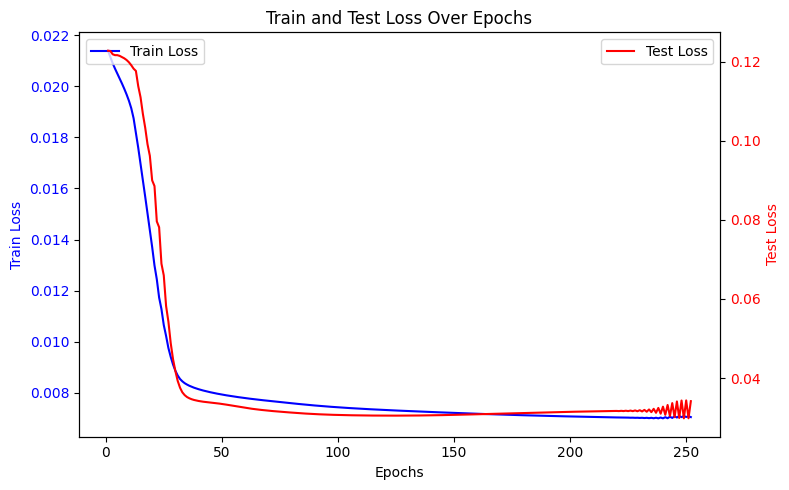

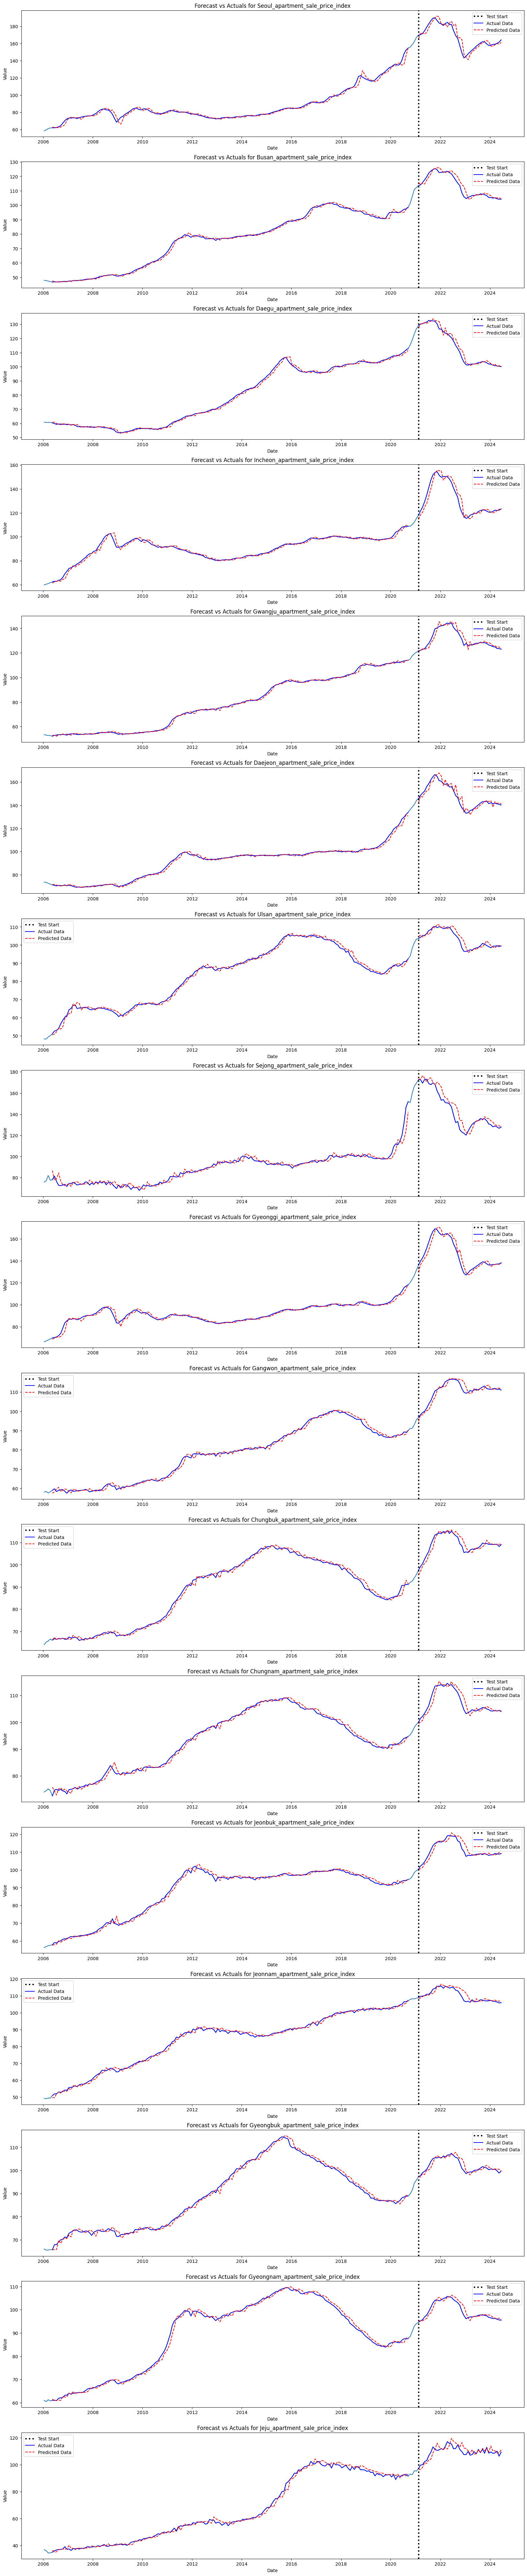

In [57]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    xPatch_model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = xPatch_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    xPatch_model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = xPatch_model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(xPatch_model.state_dict(), f"./xPatch{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
xPatch_model.load_state_dict(torch.load(f"./xPatch{version}.pth"))  # 최적 모델 로드
xPatch_model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = xPatch_model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = xPatch_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    

In [76]:
# Load model and Evaluate
xPatch_model.load_state_dict(torch.load(f"./xPatch{version}.pth"))  # 최적 모델 로드
xPatch_model.eval()

with torch.no_grad():
    for data, target in test_dl:
        test_output = xPatch_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    

<Figure size 2000x10200 with 0 Axes>